In [26]:
%env DB_HOST=mongodb://localhost/openpath_prod_ca_ebike
import emission.core.get_database as edb
import emission.storage.timeseries.aggregate_timeseries as esta
import emission.storage.timeseries.builtin_timeseries as estb
import emission.core.get_database as gdb

env: DB_HOST=mongodb://localhost/openpath_prod_ca_ebike


In [27]:
# Count the total number of documents with metadata.key = "stats/pipeline_time" in Stage_timeseries
pipeline_time_count = gdb.get_timeseries_db().count_documents({
    "metadata.key": "stats/pipeline_time"
})
print(f"Total documents in Stage_timeseries with metadata.key 'stats/pipeline_time': {pipeline_time_count}")


Total documents in Stage_timeseries with metadata.key 'stats/pipeline_time': 215954


In [28]:
# Count the total number of documents with metadata.key = "stats/dashboard_time" in Stage_timeseries
dashboard_time_count = gdb.get_timeseries_db().count_documents({
    "metadata.key": "stats/dashboard_time"
})
print(f"Total documents in Stage_timeseries with metadata.key 'stats/dashboard_time': {dashboard_time_count}")


Total documents in Stage_timeseries with metadata.key 'stats/dashboard_time': 5960


In [29]:
# Fetch documents with metadata.key = "stats/pipeline_time"
pipeline_docs_cursor = gdb.get_timeseries_db().find({
    "metadata.key": "stats/pipeline_time"
})

# Display a sample of the documents
import pprint
pipeline_docs = list(pipeline_docs_cursor)
if pipeline_docs:
    single_doc = pipeline_docs[0]
    print("Single Document:")
    pprint.pprint(single_doc)
else:
    print("No documents found for 'stats/pipeline_time'.")

# Fetch multiple documents
pipeline_docs_sample = pipeline_docs[:5]  # Get first 5 documents
print("\nMultiple Documents:")
for doc in pipeline_docs_sample:
    pprint.pprint(doc)


Single Document:
{'_id': ObjectId('64e2560df8133d4ee854e6ce'),
 'data': {'name': 'USERCACHE',
          'reading': 0.04747532098554075,
          'ts': 1692554765.890673},
 'metadata': {'key': 'stats/pipeline_time',
              'platform': 'server',
              'time_zone': 'America/Los_Angeles',
              'write_fmt_time': '2023-08-20T11:06:05.890745-07:00',
              'write_local_dt': {'day': 20,
                                 'hour': 11,
                                 'minute': 6,
                                 'month': 8,
                                 'second': 5,
                                 'timezone': 'America/Los_Angeles',
                                 'weekday': 6,
                                 'year': 2023},
              'write_ts': 1692554765.890745},
 'user_id': UUID('4736e8ba-cb1e-447c-be13-dbb1cd99aceb')}

Multiple Documents:
{'_id': ObjectId('64e2560df8133d4ee854e6ce'),
 'data': {'name': 'USERCACHE',
          'reading': 0.0474753209855407

In [30]:
import pandas as pd

documents_cursor = gdb.get_timeseries_db().find({"metadata.key": "stats/pipeline_time"})
documents = list(documents_cursor)
df = pd.json_normalize(documents)

# Display DataFrame columns and data types
print("\nDataFrame Columns and Data Types:")
print(df.dtypes)

# Display summary statistics
print("\nDataFrame Description:")
print(df.describe(include='all'))

# Display the first few rows
print("\nFirst Five Rows of DataFrame:")
print(df.head())
print(len(df))



DataFrame Columns and Data Types:
_id                                  object
user_id                              object
metadata.key                         object
metadata.platform                    object
metadata.write_ts                   float64
metadata.time_zone                   object
metadata.write_local_dt.year          int64
metadata.write_local_dt.month         int64
metadata.write_local_dt.day           int64
metadata.write_local_dt.hour          int64
metadata.write_local_dt.minute        int64
metadata.write_local_dt.second        int64
metadata.write_local_dt.weekday       int64
metadata.write_local_dt.timezone     object
metadata.write_fmt_time              object
data.name                            object
data.ts                             float64
data.reading                        float64
dtype: object

DataFrame Description:
                             _id                               user_id  \
count                     215954                             

In [31]:
# Define the aggregation pipeline as a function
def process_pipeline_data(data_df):
    # Filter documents where metadata.key is 'stats/pipeline_time'
    filtered_df = data_df[data_df['metadata.key'] == 'stats/pipeline_time']
    
    # Group by year, month, and day to calculate statistics on `data.reading`
    grouped_df = filtered_df.groupby(
        ['metadata.write_local_dt.year', 'metadata.write_local_dt.month', 'metadata.write_local_dt.day']
    ).agg(
        avgPipelineTime=('data.reading', 'mean'),
        minPipelineTime=('data.reading', 'min'),
        maxPipelineTime=('data.reading', 'max'),
        count=('data.reading', 'size'),
        medianPipelineTime=('data.reading', 'median'),
        stdPipelineTime=('data.reading', 'std')
    ).reset_index()

    return grouped_df

# Convert the aggregation results into a Pandas DataFrame for easier data manipulation
agg_df = process_pipeline_data(df)

# Display the first few rows of the aggregated DataFrame
print("\nAggregation Results:")
print(agg_df)



Aggregation Results:
     metadata.write_local_dt.year  metadata.write_local_dt.month  \
0                            2023                              6   
1                            2023                              6   
2                            2023                              6   
3                            2023                              6   
4                            2023                              7   
..                            ...                            ...   
336                          2024                              5   
337                          2024                              5   
338                          2024                              9   
339                          2024                              9   
340                          2024                              9   

     metadata.write_local_dt.day  avgPipelineTime  minPipelineTime  \
0                             27         0.051048         0.007456   
1                    

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
# Set the visual style
sns.set(style="whitegrid")


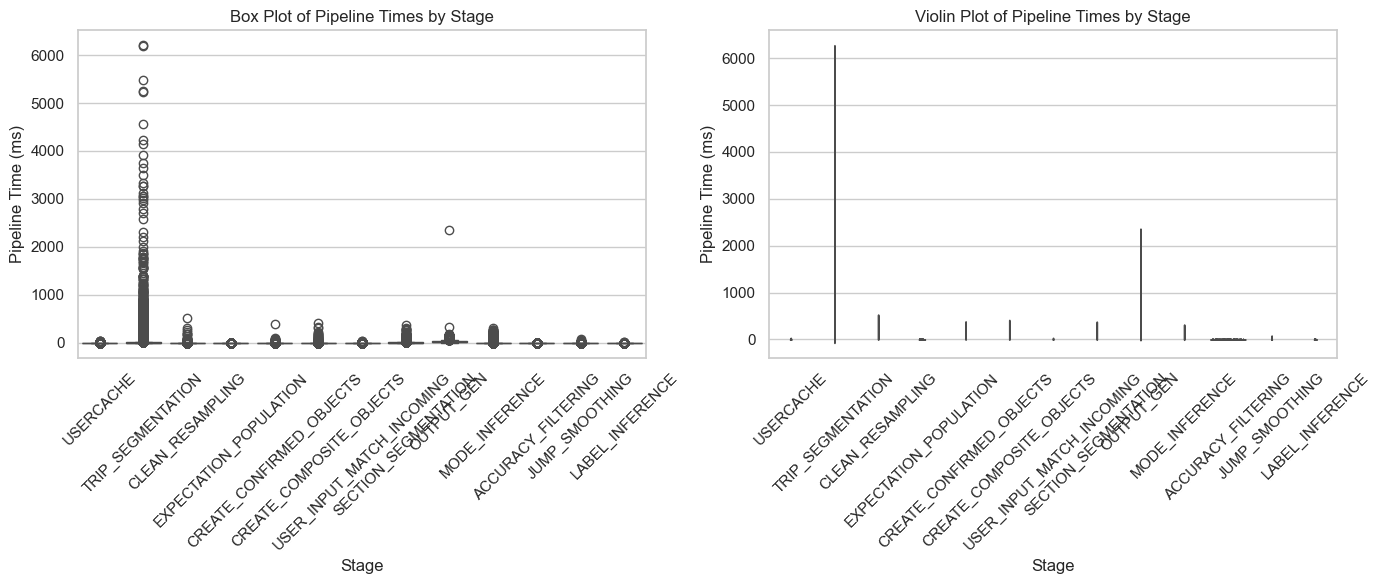

In [34]:
# Function to visualize the distribution of pipeline times
def visualize_pipeline_time_distribution(data_df):
    plt.figure(figsize=(14, 6))
    
    # Box Plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='data.name', y='data.reading', data=data_df)
    plt.title('Box Plot of Pipeline Times by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time (ms)')  # Added units in milliseconds
    plt.xticks(rotation=45)
    
    # Violin Plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x='data.name', y='data.reading', data=data_df, inner='quartile')
    plt.title('Violin Plot of Pipeline Times by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time (ms)')  # Added units in milliseconds
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualize the distribution of pipeline times
visualize_pipeline_time_distribution(df)


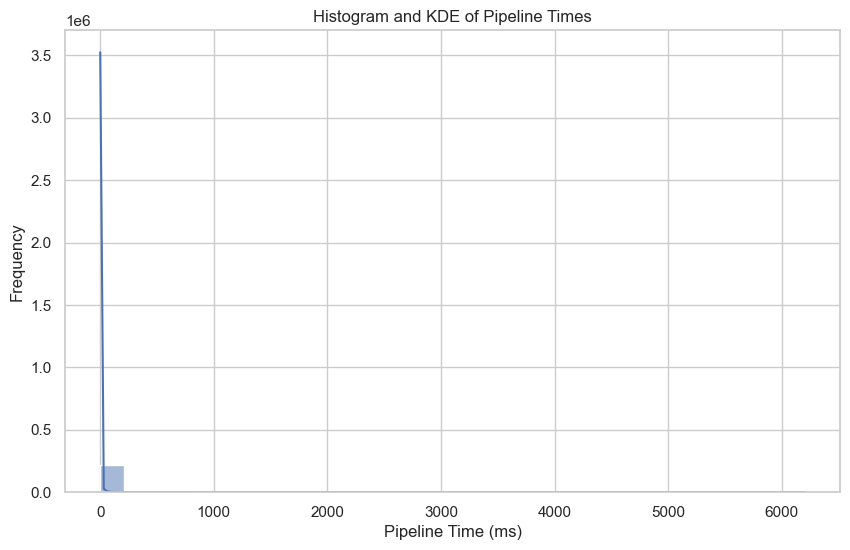

In [35]:
# Additional Analysis: Histogram and KDE
def plot_histogram_kde(data_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(data_df['data.reading'], bins=30, kde=True)
    plt.title('Histogram and KDE of Pipeline Times')
    plt.xlabel('Pipeline Time (ms)')  # Units in milliseconds for x-axis
    plt.ylabel('Frequency')  # No units needed for frequency on y-axis
    plt.show()

# Plot the histogram and KDE of pipeline times
plot_histogram_kde(df)


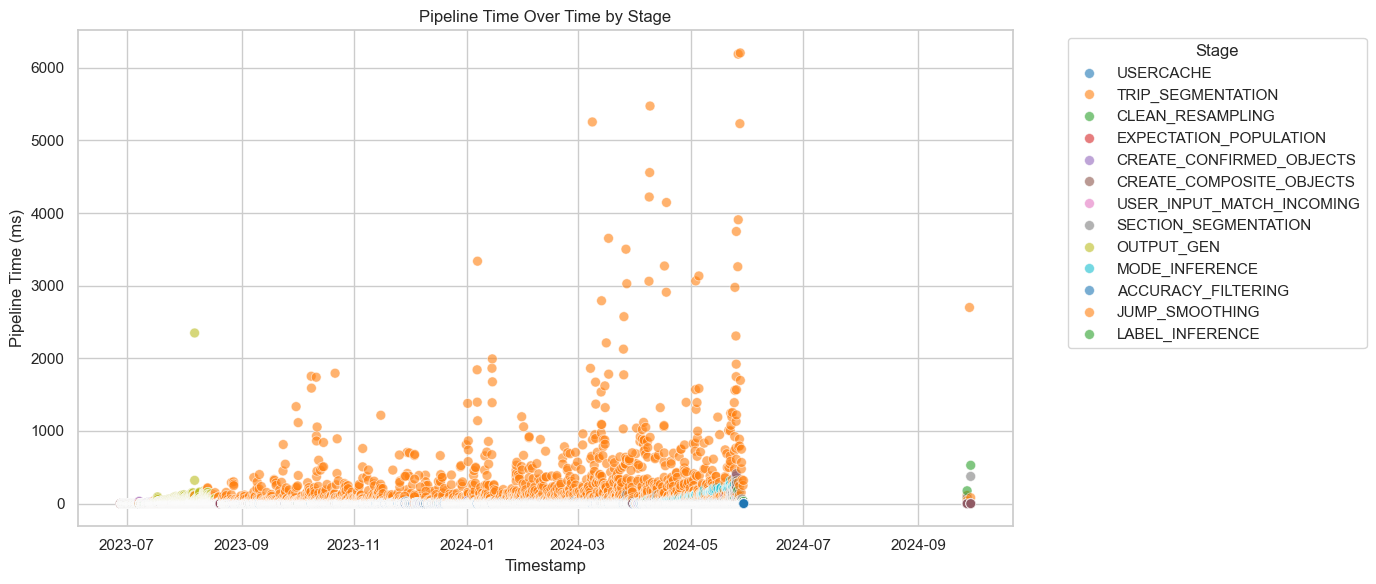

In [36]:
# Scatter Plot: Pipeline Time vs. Timestamp
def plot_scatter_time(data_df):
    plt.figure(figsize=(14, 6))
    
    # Convert write_fmt_time to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(data_df['metadata.write_fmt_time']):
        data_df['metadata.write_fmt_time'] = pd.to_datetime(data_df['metadata.write_fmt_time'], errors='coerce')
    
    # Ensure there are no missing values in 'metadata.write_fmt_time' and 'data.reading'
    data_df = data_df.dropna(subset=['metadata.write_fmt_time', 'data.reading', 'data.name'])
    
    # Create the scatter plot with the data parameter
    sns.scatterplot(
        x='metadata.write_fmt_time',
        y='data.reading',
        hue='data.name',
        data=data_df,           # Pass the DataFrame here
        alpha=0.6,
        palette='tab10',
        s=50
    )
    
    plt.title('Pipeline Time Over Time by Stage')
    plt.xlabel('Timestamp')
    plt.ylabel('Pipeline Time (ms)')
    plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Execute the corrected function
plot_scatter_time(df)



Correlation Matrix:
                               data.reading  metadata.write_local_dt.year  \
data.reading                       1.000000                      0.043321   
metadata.write_local_dt.year       0.043321                      1.000000   
metadata.write_local_dt.month     -0.026421                     -0.858697   
metadata.write_local_dt.day        0.001649                     -0.014449   

                               metadata.write_local_dt.month  \
data.reading                                       -0.026421   
metadata.write_local_dt.year                       -0.858697   
metadata.write_local_dt.month                       1.000000   
metadata.write_local_dt.day                        -0.031682   

                               metadata.write_local_dt.day  
data.reading                                      0.001649  
metadata.write_local_dt.year                     -0.014449  
metadata.write_local_dt.month                    -0.031682  
metadata.write_local_dt.day 

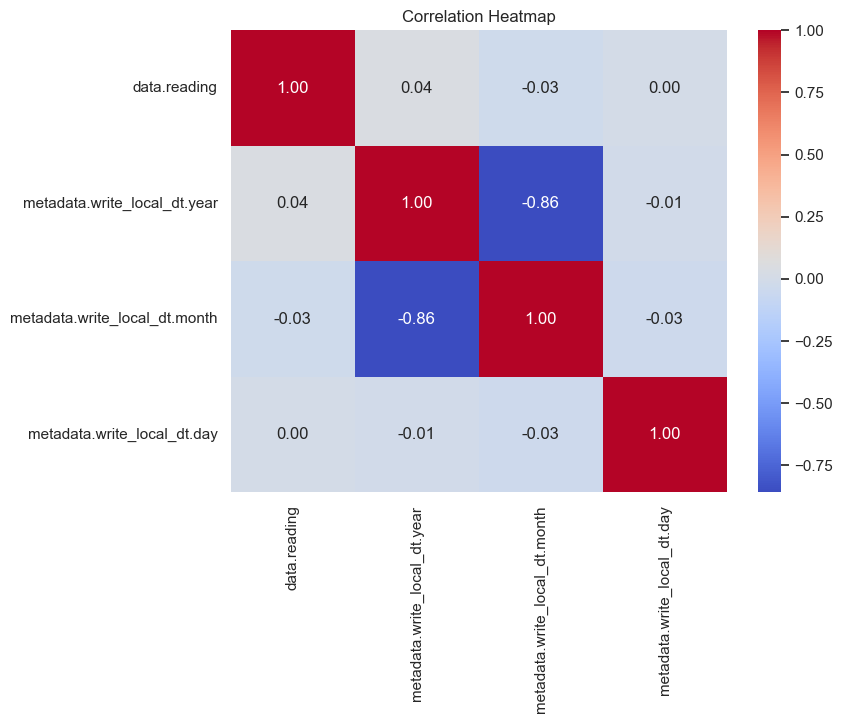

Correlation Heatmap displayed.


In [45]:
# Correlation Analysis
def correlation_analysis(data_df):
    numeric_cols = ['data.reading', 'metadata.write_local_dt.year', 'metadata.write_local_dt.month', 'metadata.write_local_dt.day']
    corr = data_df[numeric_cols].corr()
    print("\nCorrelation Matrix:")
    print(corr)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
    print("Correlation Heatmap displayed.")

correlation_analysis(df)



Summary Statistics by Stage:
                    data.name       mean     median       min          max  \
0          ACCURACY_FILTERING   0.025895   0.017583  0.003365     0.555279   
1            CLEAN_RESAMPLING   1.982233   0.175181  0.015944   527.788498   
2    CREATE_COMPOSITE_OBJECTS   1.705596   0.613373  0.059748   413.261087   
3    CREATE_CONFIRMED_OBJECTS   1.453298   0.165852  0.006439   383.443585   
4      EXPECTATION_POPULATION   0.088930   0.064937  0.004779     3.951730   
5              JUMP_SMOOTHING   0.994608   0.153088  0.011169    81.528543   
6             LABEL_INFERENCE   0.183848   0.090049  0.004788    12.162497   
7              MODE_INFERENCE   2.523170   0.098755  0.011924   312.257347   
8                  OUTPUT_GEN  24.278679  16.539417  0.008508  2348.946196   
9        SECTION_SEGMENTATION   5.901243   0.454534  0.011720   375.005335   
10          TRIP_SEGMENTATION  42.703585   0.652166  0.015374  6203.543786   
11                  USERCACHE   0.

/var/folders/8j/284cnbzn2tzbfljhtsr17gsx2490jk/T/ipykernel_43411/1996108215.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='data.name', y='mean', data=summary, palette='viridis')


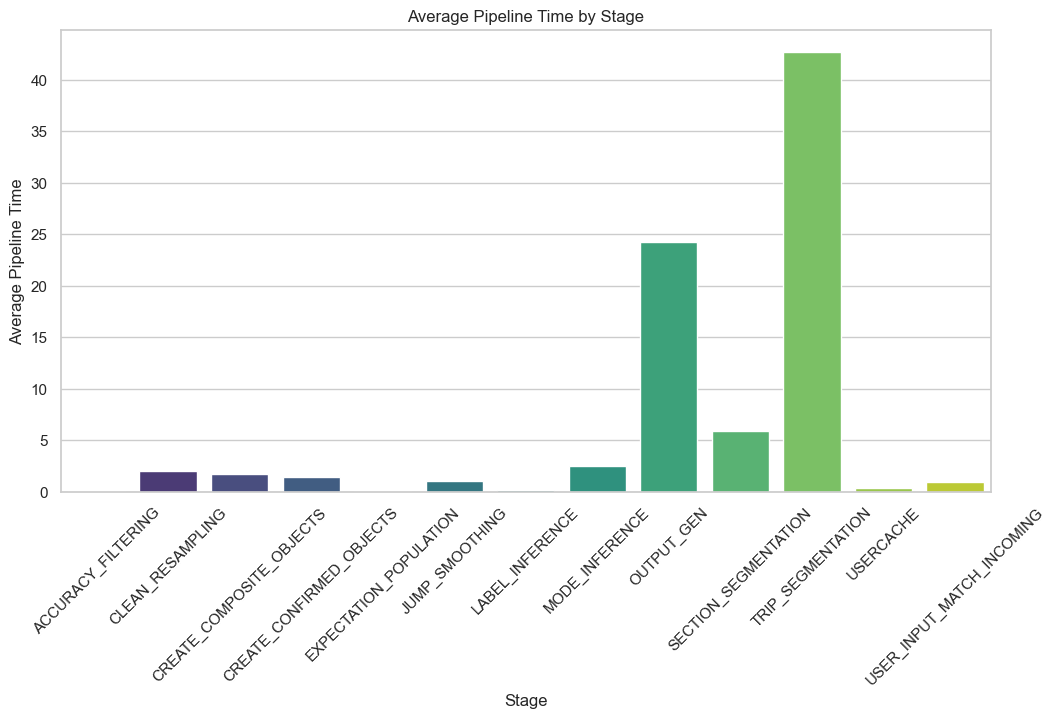

In [46]:
# Summary Statistics by Stage
def summary_stats_by_stage(data_df):
    summary = data_df.groupby('data.name')['data.reading'].agg(['mean', 'median', 'min', 'max', 'std', 'count']).reset_index()
    print("\nSummary Statistics by Stage:")
    print(summary)
    
    # Plotting the summary statistics
    plt.figure(figsize=(12, 6))
    sns.barplot(x='data.name', y='mean', data=summary, palette='viridis')
    plt.title('Average Pipeline Time by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Average Pipeline Time')
    plt.xticks(rotation=45)
    plt.show()

summary_stats_by_stage(df)


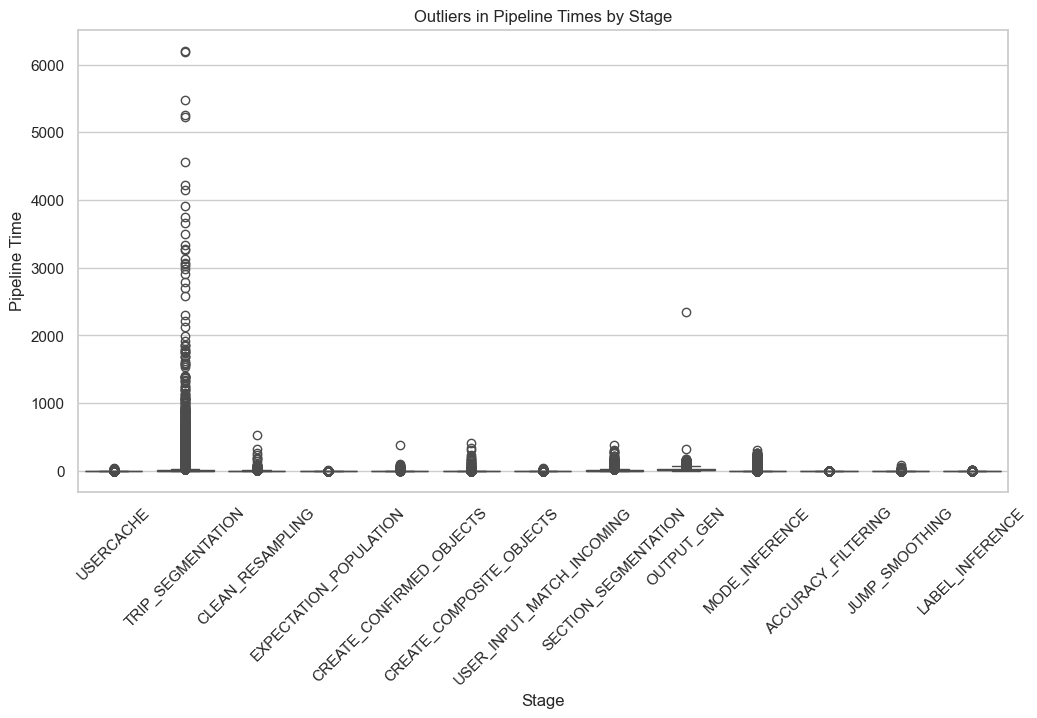

In [47]:
# Identifying Outliers
def identify_outliers(data_df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='data.name', y='data.reading', data=data_df)
    plt.title('Outliers in Pipeline Times by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time')
    plt.xticks(rotation=45)
    plt.show()

identify_outliers(df)


In [48]:
# Function to get pipeline time by stage for each user and across all users
def get_pipeline_time_by_stage(data_df):
    # Calculate the average time for each stage (data.name) for each user
    user_stage_avg = data_df.groupby(['user_id', 'data.name'])['data.reading'].mean().reset_index()
    
    # Calculate the average time for each stage across all users
    all_users_stage_avg = data_df.groupby('data.name')['data.reading'].mean().reset_index()
    
    return user_stage_avg, all_users_stage_avg


In [49]:
# Get the pipeline time by stage
user_stage_avg_df, all_users_stage_avg_df = get_pipeline_time_by_stage(df)

#Display the results
print("Average Stage Times for Each User (First 5 Rows):")
print(user_stage_avg_df)

print("\nAverage Stage Times Across All Users:")
print(all_users_stage_avg_df)


Average Stage Times for Each User (First 5 Rows):
                                  user_id                  data.name  \
0    1c5bb177-3587-48c3-888d-e18462a20bfd         ACCURACY_FILTERING   
1    1c5bb177-3587-48c3-888d-e18462a20bfd           CLEAN_RESAMPLING   
2    1c5bb177-3587-48c3-888d-e18462a20bfd   CREATE_COMPOSITE_OBJECTS   
3    1c5bb177-3587-48c3-888d-e18462a20bfd   CREATE_CONFIRMED_OBJECTS   
4    1c5bb177-3587-48c3-888d-e18462a20bfd     EXPECTATION_POPULATION   
..                                    ...                        ...   
160  f71a8416-d8d8-438c-9f75-dca23fc9fc00             MODE_INFERENCE   
161  f71a8416-d8d8-438c-9f75-dca23fc9fc00       SECTION_SEGMENTATION   
162  f71a8416-d8d8-438c-9f75-dca23fc9fc00          TRIP_SEGMENTATION   
163  f71a8416-d8d8-438c-9f75-dca23fc9fc00                  USERCACHE   
164  f71a8416-d8d8-438c-9f75-dca23fc9fc00  USER_INPUT_MATCH_INCOMING   

     data.reading  
0        0.023265  
1        2.690368  
2        2.070234  
3    

/var/folders/8j/284cnbzn2tzbfljhtsr17gsx2490jk/T/ipykernel_43411/3201168276.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='data.name', y='data.reading', data=all_users_stage_avg_df, palette='magma')


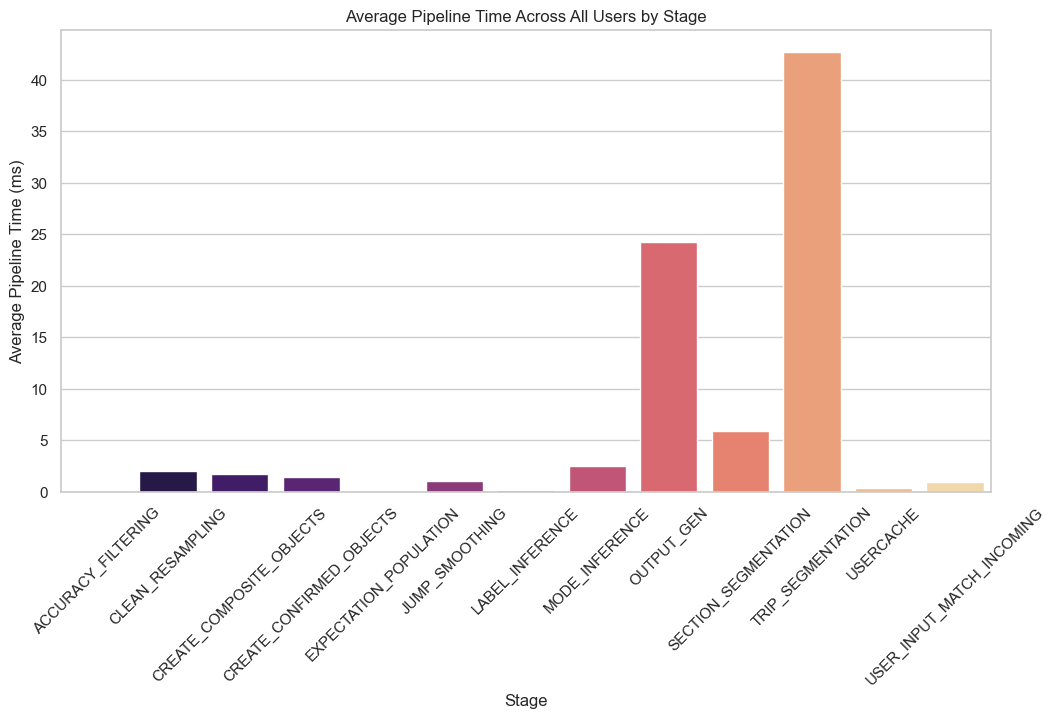

In [51]:
# Visualize Average Pipeline Time Across All Users by Stage
def plot_average_pipeline_time(all_users_stage_avg_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='data.name', y='data.reading', data=all_users_stage_avg_df, palette='magma')
    plt.title('Average Pipeline Time Across All Users by Stage')
    plt.xlabel('Stage')
    plt.ylabel('Average Pipeline Time (ms)')
    plt.xticks(rotation=45)
    plt.show()

plot_average_pipeline_time(all_users_stage_avg_df)


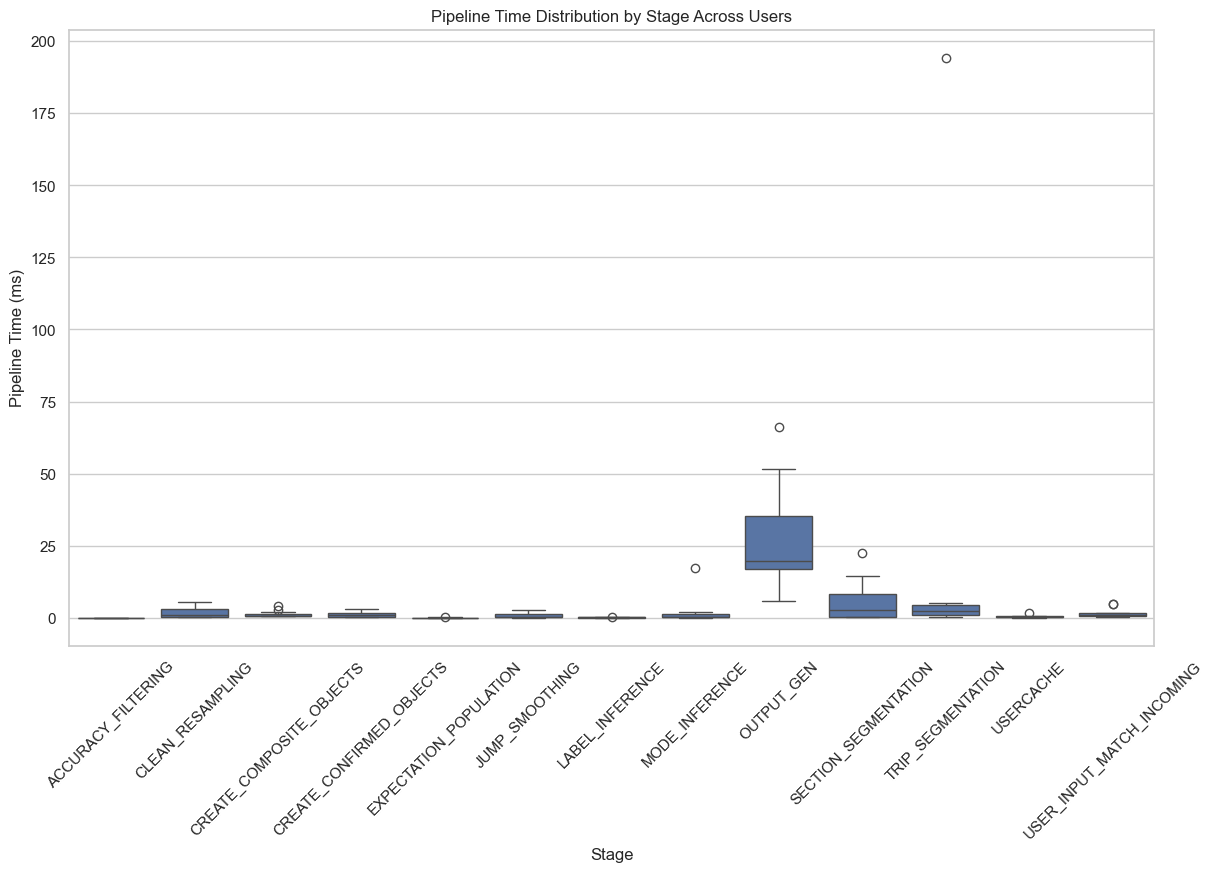

In [53]:
# Visualize User-Specific Pipeline Times
def plot_user_pipeline_times(user_stage_avg_df):
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='data.name', y='data.reading', data=user_stage_avg_df)
    plt.title('Pipeline Time Distribution by Stage Across Users')
    plt.xlabel('Stage')
    plt.ylabel('Pipeline Time (ms)')
    plt.xticks(rotation=45)
    plt.show()

plot_user_pipeline_times(user_stage_avg_df)


In [55]:
# Investigate Low Average Pipeline Time
def investigate_low_avg(data_df):
    # Check for zeros or extremely low values
    low_threshold = data_df['data.reading'].quantile(0.05)
    low_values = data_df[data_df['data.reading'] < low_threshold]
    print(f"\nNumber of records with pipeline time below the 5th percentile ({low_threshold}): {low_values.shape[0]}")
    
    if not low_values.empty:
        print("\nSample of Low Pipeline Time Records:")
        print(low_values.head())

investigate_low_avg(df)



Number of records with pipeline time below the 5th percentile (0.023715552739304258): 10798

Sample of Low Pipeline Time Records:
                         _id                               user_id  \
8   649b331e7c601c474fb00106  1eda07f4-3132-4db5-a791-129ec95e7fae   
9   649b331e7c601c474fb00109  1eda07f4-3132-4db5-a791-129ec95e7fae   
11  649b331f7c601c474fb00111  1eda07f4-3132-4db5-a791-129ec95e7fae   
12  649b412f07aba8c4585663b2  1eda07f4-3132-4db5-a791-129ec95e7fae   
14  649b412f07aba8c4585663b6  1eda07f4-3132-4db5-a791-129ec95e7fae   

           metadata.key metadata.platform  metadata.write_ts  \
8   stats/pipeline_time            server       1.687893e+09   
9   stats/pipeline_time            server       1.687893e+09   
11  stats/pipeline_time            server       1.687893e+09   
12  stats/pipeline_time            server       1.687896e+09   
14  stats/pipeline_time            server       1.687896e+09   

     metadata.time_zone  metadata.write_local_dt.year  \
8   Am